<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 – Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Regresión Logística - Implementación</h2>

In [72]:
# REGRESIÓN LOGÍSTICA => Coche para estudiante

# Aquí usaremos la regresión logística para separar los coches de nuestro dataset en dos grupos:
#   1 -> coche recomendable para un estudiante universitario
#   0 -> coche que no lo es
#
# Para decidir qué coche es bueno para estudiante nos hemos guiado por caracteristicas de un alumno medio de universidad:
#   - que no sea muy caro,
#   - que gaste poco (economy alta),
#   - que no esté en muy mal estado para no tener muchas averias (condition decente)
#
# Por lo que definiremos una variable binaria (estudiante_ok), y como variables de entrada: price, km, economy, condition y rating. A partir de ahí aplicaremos exactamente
# el esquema de regresión logística de la EPD 3

### 1. Importaciones y lectura del dataset

In [73]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"current price": "price"})

In [75]:
#Creamos la variable binaria de estudiante_ok
precio_medio = df["price"].mean()

df["estudiante_ok"] = ((df["economy"] >= 8) & (df["condition"] >= 3) & (df["price"] <= precio_medio)).astype(int)

print("Primeras filas + estudiante_ok:\n")
print(df[["price", "km", "economy", "condition", "rating", "estudiante_ok"]].head())

Primeras filas + estudiante_ok:

      price      km  economy  condition  rating  estudiante_ok
0  351318.0   78945       14          2       1              0
1  285001.5  117220        9          9       5              1
2  215386.0  132538       15          8       2              1
3  244295.5  101065       11          3       4              1
4  531114.5   61559       12          9       3              0


### 2. Variables de entrada X y la clase y | Normalización de características

In [76]:
columnas_X = ["price", "km", "economy", "condition", "rating"]
#X = df[columnas_X].copy()
X_full = df[columnas_X].copy()
y_full = df[["estudiante_ok"]].copy()

#Normalizamos porque nos sale "overflow encountered in exp" en punto "6. Theta, coste y gradiente iniciales"
def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_log, desv_log = featureNormalize(X_full)

unos = np.ones(len(X_norm))
X = X_norm.copy()
X.insert(0, "ones", unos)

print("\nShape de X:", X.shape)
print("Shape de y:", y_full.shape)


Shape de X: (1000, 6)
Shape de y: (1000, 1)


### 3. Función sigmoide

In [77]:
def sigmoid(z):
    # Clipear z para evitar overflow en exp(-z)
    # Cuando z es muy grande (>500), exp(-z) -> 0, entonces sigmoid -> 1
    # Cuando z es muy pequeño (<-500), exp(-z) -> infinito, entonces sigmoid -> 0
    z = np.clip(z, -500, 500)
    denominador = 1 + np.exp(-z)
    g = 1 / denominador
    return g

### 4. Función coste (vectorizada)

In [78]:
def costFunction(theta, X, y):
    m = len(y)
    Xn = X.values # m,n
    yn = y # yn vector de 1D
    z = Xn.dot(theta) # m
    
    h = sigmoid(z) #m
   #Evitamos el log(0) ya que nha encontrado valores 0 o 1 en "6. Theta, coste y gradiente iniciales"
    eps = 1e-8
    h = np.clip(h, eps, 1 - eps)
    
    termino1 = yn * np.log(h)
    termino2 = (1 - yn) * np.log(1 - h)

    J = (-1/m) * np.sum(termino1 + termino2)
    return J

### 5. Función gradiente (vectorizada)

In [79]:
def gradientFunction(theta, X, y_vec):
    m = len(y_vec)
    Xn = X.values
    z = Xn.dot(theta)
    h = sigmoid(z)
    grad = (1/m) * (Xn.T.dot(h - y_vec)) # n
    return grad

### 6. Función predicción

In [80]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

### 7. Validación cruzada - 10 repeticiones (90%/10%)

In [81]:

np.random.seed(0) #mismos splits

alpha = 0.01 #fmin_cg hace su propio paso, este alpha no se usa aqui
maxiter = 5000 #nmax iteraciones fmin_cg (aumentado de 400 a 5000)
n_reps = 10 #10 particiones

accuracy_list = []
TP_list, TN_list, FP_list, FN_list = [], [], [], []

theta_opt_main = None
media_main = None
desv_main = None
cost_history_main = None

for rep in range(n_reps):
    m = len(X_full)
    idx = np.random.permutation(m)
    train_size = int(0.9 * m)

    #90% train, 10% test -> recomendado por la profesora porque no tenemos muchisimos datos
    idx_train = idx[:train_size]
    idx_test  = idx[train_size:]

    X_train_raw = X_full.iloc[idx_train].copy()
    y_train = y_full.iloc[idx_train].copy() #(m_train,1)

    X_test_raw = X_full.iloc[idx_test].copy()
    y_test = y_full.iloc[idx_test].copy()

    #Normalizamos SOLO estadisticas train
    X_train_norm, media, desv = featureNormalize(X_train_raw)
    X_test_norm = (X_test_raw - media) / desv

    #print("DEBUG: tamaño de X_train:", X_train_norm.shape)

    #Añadimos columna de unos
    X_train_norm.insert(0, "ones", 1)
    X_test_norm.insert(0, "ones", 1)

    # heta inicial a ceros (igual que en EPD)
    theta_ini = np.zeros(X_train_norm.shape[1])
    y_train_vec = y_train.to_numpy().flatten()

    #print(theta_ini)

    #Guardar historia de coste solo para esta rep.
    cost_history_rep = []
    def guardar_coste_log(theta_actual):
        c = costFunction(theta_actual, X_train_norm, y_train_vec)
        cost_history_rep.append(c)

    #Entrenamos solo con conjunto de entrenamiento
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_train_norm, y_train_vec),
        maxiter=maxiter,
        callback=guardar_coste_log,
        disp=False # para que no saque todo el log en cada rep.
    )

    #print(theta_opt)

    #Guardamos PRIMERA repetición para dibujar la gráfica y usar como modelo
    if rep == 0:
        theta_opt_main = theta_opt
        media_main = media
        desv_main = desv
        cost_history_main = cost_history_rep

    #Prediccion en el conjunto de test
    y_pred_test = predict(theta_opt, X_test_norm, bool_round=True).astype(int)
    y_test_vec = y_test.to_numpy().flatten()

    #Métricas en test
    accuracy = np.mean(y_pred_test == y_test_vec)
    TP = np.sum((y_test_vec == 1) & (y_pred_test == 1))
    TN = np.sum((y_test_vec == 0) & (y_pred_test == 0))
    FP = np.sum((y_test_vec == 0) & (y_pred_test == 1))
    FN = np.sum((y_test_vec == 1) & (y_pred_test == 0))

    accuracy_list.append(accuracy)
    TP_list.append(TP); TN_list.append(TN); FP_list.append(FP); FN_list.append(FN)

    print(f"Repetición {rep+1} / Accuracy test = {accuracy:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

print("\nMEDIA de las 10 repeticiones (TEST):")
print("Accuracy medio :", np.mean(accuracy_list))
print("TP medio       :", np.mean(TP_list))
print("TN medio       :", np.mean(TN_list))
print("FP medio       :", np.mean(FP_list))
print("FN medio       :", np.mean(FN_list))

#Trabajamos con modelo de la primera repetición (gráficas, ejemplo...)
theta_opt = theta_opt_main
media_log = media_main
desv_log = desv_main
cost_history_log = cost_history_main


Repetición 1 / Accuracy test = 0.850  (TP=28, TN=57, FP=8, FN=7)
Repetición 2 / Accuracy test = 0.890  (TP=27, TN=62, FP=2, FN=9)


Repetición 3 / Accuracy test = 0.870  (TP=27, TN=60, FP=7, FN=6)
Repetición 4 / Accuracy test = 0.880  (TP=32, TN=56, FP=8, FN=4)
Repetición 5 / Accuracy test = 0.840  (TP=37, TN=47, FP=8, FN=8)
Repetición 6 / Accuracy test = 0.860  (TP=30, TN=56, FP=5, FN=9)
Repetición 7 / Accuracy test = 0.850  (TP=35, TN=50, FP=6, FN=9)
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP medio       : 6.1
FN medio       : 7.8
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP 

### 8. Theta, coste y gradiente iniciales

In [82]:
n_param = X.shape[1]
theta_ini = np.zeros(n_param) #vector 1D
y_vec = y_full.to_numpy().flatten() #m

print("\nCoste inicial con theta (0): ", costFunction(theta_ini, X, y_vec))
print("Gradiente inicial: \n", gradientFunction(theta_ini, X, y_vec))

#Para la gráfica
cost_history_log = []
def guardar_coste_log(theta):
    c = costFunction(theta, X, y_vec)
    cost_history_log.append(c)

# Optimizacion fmin_cg
theta_opt = op.fmin_cg(
    f = costFunction,
    x0 = theta_ini,
    fprime = gradientFunction,
    args = (X, y_vec),
    maxiter = 5000,  # aumentado de 400 a 5000
    callback = guardar_coste_log,
    disp=False  # para suprimir advertencias
)

print("\nTheta optimo:")
print(theta_opt)



Coste inicial con theta (0):  0.6931471805599454
Gradiente inicial: 
 [ 0.092       0.3397436  -0.33782546 -0.01927776 -0.09611219  0.0307273 ]

Theta optimo:
[-1.04196569 -3.10130639  0.22287657  0.03599764  1.41479513 -0.19275264]


### 9. Gráfica de convergencia

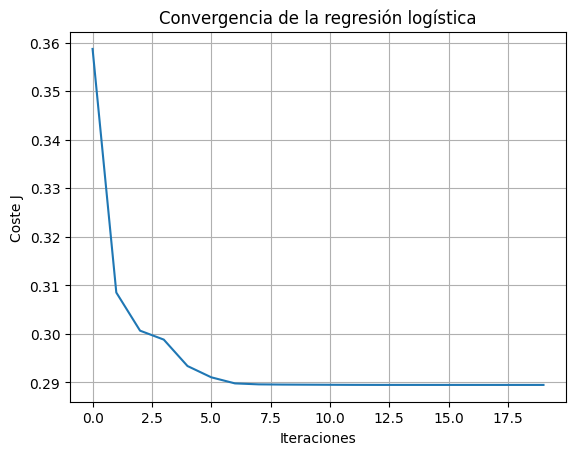

In [83]:
plt.plot(cost_history_log)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la regresión logística")
plt.grid(True)
plt.show()

### 10. Predicciones

In [84]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Necesitamos: Coche barato, con pocos km, que tenga buena economía con una condición decente y un rating medio aceptable
# Valores seleccionados [price, km, economy, condition, rating]
ejemplo_coche_raw = [200000, 50000, 9, 4, 4]

# Normalizamos usando media/desviación qdel entrenamiento
ejemplo_norm = (np.array(ejemplo_coche_raw) - media_log.values) / desv_log.values

# Añadimos el 1 inicial
fila_ejemplo = np.insert(ejemplo_norm, 0, 1)  # [1, price, km, economy, condition, rating]

df_ejemplo = pd.DataFrame([fila_ejemplo], columns=X.columns)

ej_prob = predict(theta_opt, df_ejemplo, bool_round=False)
ej_clase = predict(theta_opt, df_ejemplo, bool_round=True)

print("\nEjemplo de coche para estudiante:")
print("Características originales (sin normalizar):", ejemplo_coche_raw)
print("Probabilidad de ser 'estudiante_ok':", float(ej_prob[0]))
print("Predicción (0/1):", int(ej_clase[0]))


Ejemplo de coche para estudiante:
Características originales (sin normalizar): [200000, 50000, 9, 4, 4]
Probabilidad de ser 'estudiante_ok': 0.5459667515108496
Predicción (0/1): 1


### 11. Evaluación usando TODO el dataset

In [85]:
X_full_norm = (X_full - media_log) / desv_log
X_full_norm.insert(0, "ones", 1)

y_pred_full = predict(theta_opt, X_full_norm, bool_round=True).astype(int)
y_real_full = y_full.to_numpy().flatten()

accuracy_full = np.mean(y_pred_full == y_real_full)
print("\nAccuracy del modelo sobre TODO el dataset:", accuracy_full)

TP = np.sum((y_real_full == 1) & (y_pred_full == 1))
TN = np.sum((y_real_full == 0) & (y_pred_full == 0))
FP = np.sum((y_real_full == 0) & (y_pred_full == 1))
FN = np.sum((y_real_full == 1) & (y_pred_full == 0))

print("\nMatriz de confusión (todo el dataset):")
print("TP (1 bien predicho):", TP)
print("TN (0 bien predicho):", TN)
print("FP (0 mal como 1)   :", FP)
print("FN (1 mal como 0)   :", FN)


Accuracy del modelo sobre TODO el dataset: 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79
 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79


In [86]:
# Conclusiones: El modelo de regresión logística para estudiante_ok da un accuracy de 0.85 (85%), acierta aproximadamente 8 de cada 10 coches, que está bastante bien
# para las 5 variables que usamos.
#
# La matriz de confusión muestra que acierta bastantes ok y no ok, aunque hay algunos coches buenos que descarta y otros que sobrevalora, algo típico en este modelo sencillo.
#
# Viendo las gráficas de price vs economy, tanto los datos reales como las predicciones siguen la idea que teníamos: los coches más baratos y con mejor
# economía son los que salen como buenos para un estudiante.

### 12. Gráfica price vs economy (real vs predicho)

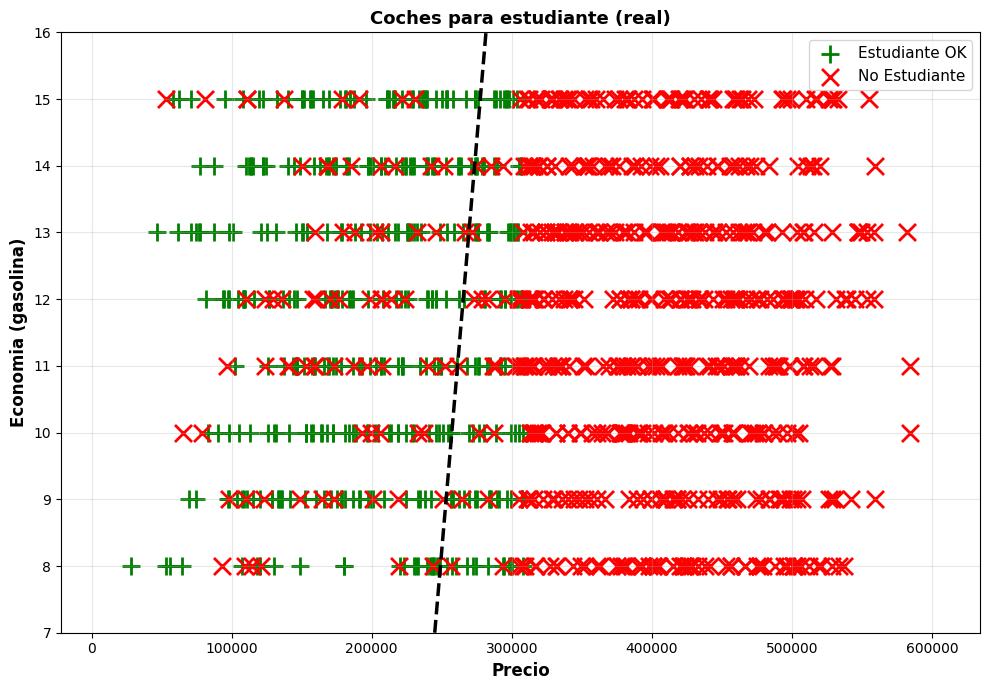

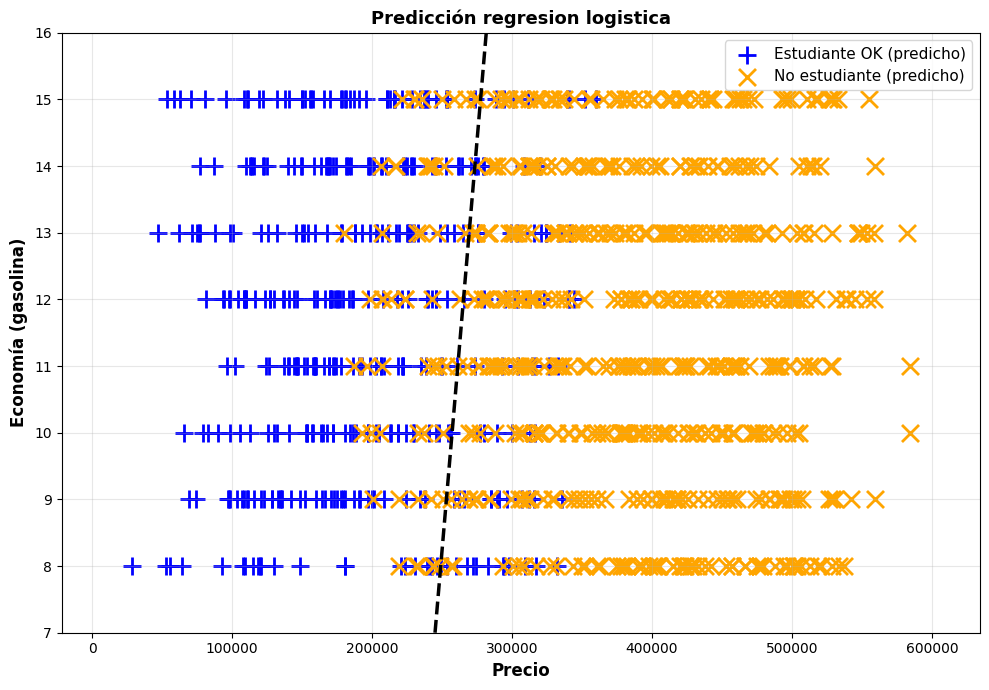

In [87]:
# En nuestro caso estamos usando 5 variables para saber si un coche es apropiado para un estudiante medio, pero como no se puede dibujar en 5D,
# hemos pensado en observar estas gráficas con dos variables bastante significativas en este caso: price y economy.
# Un estudiante principalmente (según nuestro criterio), se fija en estas dos opciones.

import matplotlib.pyplot as plt

# Dibujamos los puntos reales segun la clase
def plot_estudiante_real(df):
    
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df["price"].min() - 50000, df["price"].max() + 50000
    min_econ, max_econ = df["economy"].min() - 1, df["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="g", marker="+", s=150, label="Estudiante OK", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="r", marker="x", s=150, label="No Estudiante", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economia (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Coches para estudiante (real)", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dibujamos lo que predice nuestra regresion logistica
def plot_estudiante_pred(df_clasif):
    
    df_ok = df_clasif[df_clasif["pred_clase"] == 1]
    df_no = df_clasif[df_clasif["pred_clase"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df_clasif["price"].min() - 50000, df_clasif["price"].max() + 50000
    min_econ, max_econ = df_clasif["economy"].min() - 1, df_clasif["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))

    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="b", marker="+", s=150, label="Estudiante OK (predicho)", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=150, label="No estudiante (predicho)", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economía (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Predicción regresion logistica", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Clasificamos el dataset con el modelo aprendido
pred_clase = predict(theta_opt, X, bool_round=True)

df_clasificado = df.copy()
df_clasificado["pred_clase"] = pred_clase

# Gráfica del real
plot_estudiante_real(df)

# Gráfica del predicho
df_clasificado_plot = df_clasificado.copy()
df_clasificado_plot["price"] = df["price"]
df_clasificado_plot["economy"] = df["economy"]

plot_estudiante_pred(df_clasificado_plot)

# Conclusión: En la gráfica real los coches marcados como estudiante_ok están sobre todo en la zona de precio bajo y economía baja.
# En la grafica de predicción se ve un patrón parecido: el modelo tiende a marcar como buenos para estudiante los coches más baratos, aunque hay algunos puntos que se escapan en la economía (gasto medio gasolina)
# Para ser un modelo sencillo con 5 variables, la tasa de acierto es razonable (85%).

## ANÁLISIS: INFLUENCIA DEL NÚMERO DE ITERACIONES EN EL APRENDIZAJE

En esta sección se estudia cómo el número de iteraciones del algoritmo de optimización afecta:
- La convergencia del modelo
- La pérdida (cost function)
- La precisión de clasificación
- Posibles síntomas de sobreajuste o estancamiento

In [ ]:
### a. Entrenamiento con diferentes números de iteraciones

# Importar warnings para suprimir el OptimizeWarning al superar el número máximo de iteraciones
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings('ignore', category=OptimizeWarning)

# Definimos los números de iteraciones a probar
num_iteraciones_list = [10, 50, 100, 200, 500, 1000, 2000, 5000]

# Diccionario para almacenar resultados
resultados_iteraciones = {}

print("="*70)
print("ENTRENAMIENTO CON DIFERENTES NÚMEROS DE ITERACIONES")
print("="*70)

for max_iter in num_iteraciones_list:
    # Reiniciamos theta
    theta_temp = np.zeros(n_param)
    
    # Lista para guardar el histórico de coste
    cost_history_temp = []
    
    def callback_temp(theta):
        c = costFunction(theta, X, y_vec)
        cost_history_temp.append(c)
    
    # Optimización
    theta_optimizado = op.fmin_cg(
        f=costFunction,
        x0=theta_temp,
        fprime=gradientFunction,
        args=(X, y_vec),
        maxiter=max_iter,
        callback=callback_temp,
        disp=False  # Suprime mensajes de convergencia
    )
    
    # Predicciones
    y_pred_temp = predict(theta_optimizado, X, bool_round=True)
    
    # Métricas
    accuracy_temp = np.mean(y_pred_temp == y_real)
    coste_final = costFunction(theta_optimizado, X, y_vec)
    coste_inicial = costFunction(theta_temp, X, y_vec)
    mejora_coste = coste_inicial - coste_final
    
    # Guardamos resultados
    resultados_iteraciones[max_iter] = {
        'theta': theta_optimizado,
        'cost_history': cost_history_temp.copy(),
        'accuracy': accuracy_temp,
        'coste_final': coste_final,
        'coste_inicial': coste_inicial,
        'mejora_coste': mejora_coste,
        'num_iteraciones_reales': len(cost_history_temp)
    }
    
    print(f"\nIteraciones configuradas: {max_iter}")
    print(f"  - Iteraciones reales (convergencia): {len(cost_history_temp)}")
    print(f"  - Coste inicial: {coste_inicial:.6f}")
    print(f"  - Coste final: {coste_final:.6f}")
    print(f"  - Mejora de coste: {mejora_coste:.6f}")
    print(f"  - Accuracy: {accuracy_temp:.6f} ({accuracy_temp*100:.2f}%)")

print("\n" + "="*70)


ENTRENAMIENTO CON DIFERENTES NÚMEROS DE ITERACIONES

Iteraciones configuradas: 10
  - Iteraciones reales (convergencia): 10
  - Coste inicial: 0.693147
  - Coste final: 0.289549
  - Mejora de coste: 0.403598
  - Accuracy: 0.853000 (85.30%)

Iteraciones configuradas: 50
  - Iteraciones reales (convergencia): 20
  - Coste inicial: 0.693147
  - Coste final: 0.289499
  - Mejora de coste: 0.403648
  - Accuracy: 0.853000 (85.30%)

Iteraciones configuradas: 100
  - Iteraciones reales (convergencia): 20
  - Coste inicial: 0.693147
  - Coste final: 0.289499
  - Mejora de coste: 0.403648
  - Accuracy: 0.853000 (85.30%)

Iteraciones configuradas: 200
  - Iteraciones reales (convergencia): 20
  - Coste inicial: 0.693147
  - Coste final: 0.289499
  - Mejora de coste: 0.403648
  - Accuracy: 0.853000 (85.30%)

Iteraciones configuradas: 500
  - Iteraciones reales (convergencia): 20
  - Coste inicial: 0.693147
  - Coste final: 0.289499
  - Mejora de coste: 0.403648
  - Accuracy: 0.853000 (85.30%)

Iter

### b. Curvas de aprendizaje: Pérdida vs Iteraciones

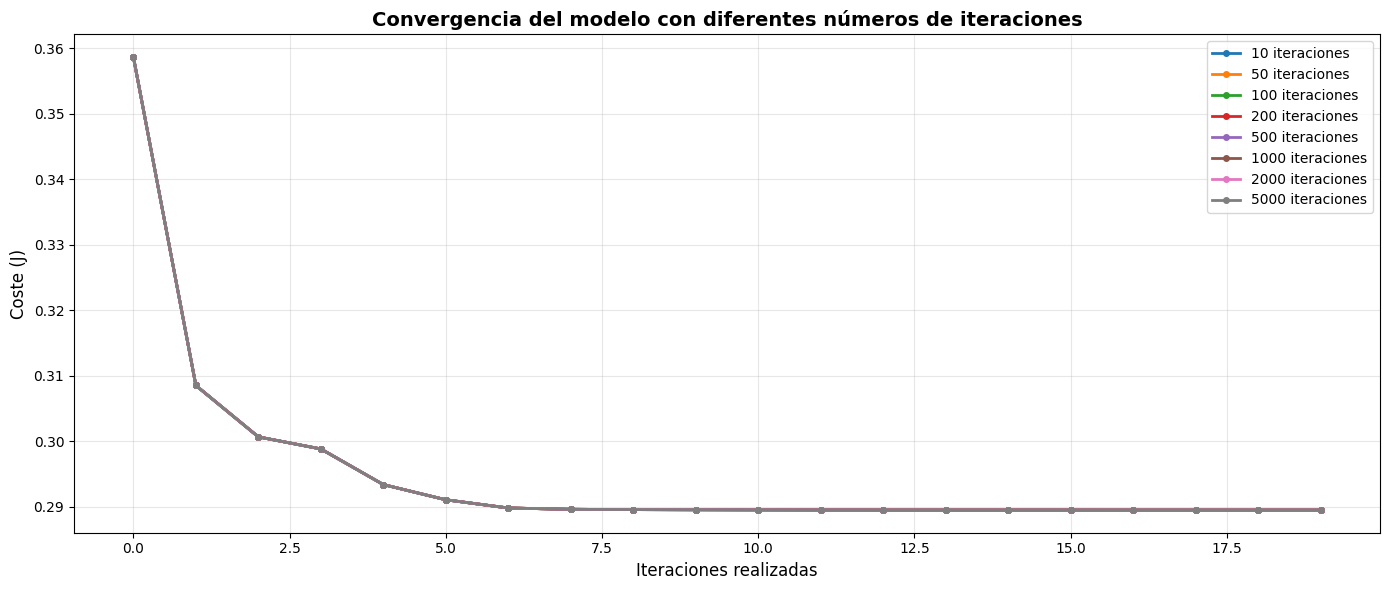

Gráfica 1: Todas las curvas de aprendizaje superpuestas para comparación visual.


In [89]:
# Gráfica 1: Todas las curvas de aprendizaje juntas
plt.figure(figsize=(14, 6))

for max_iter in num_iteraciones_list:
    cost_history = resultados_iteraciones[max_iter]['cost_history']
    plt.plot(cost_history, marker='o', label=f'{max_iter} iteraciones', linewidth=2, markersize=4)

plt.xlabel("Iteraciones realizadas", fontsize=12)
plt.ylabel("Coste (J)", fontsize=12)
plt.title("Convergencia del modelo con diferentes números de iteraciones", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Gráfica 1: Todas las curvas de aprendizaje superpuestas para comparación visual.")


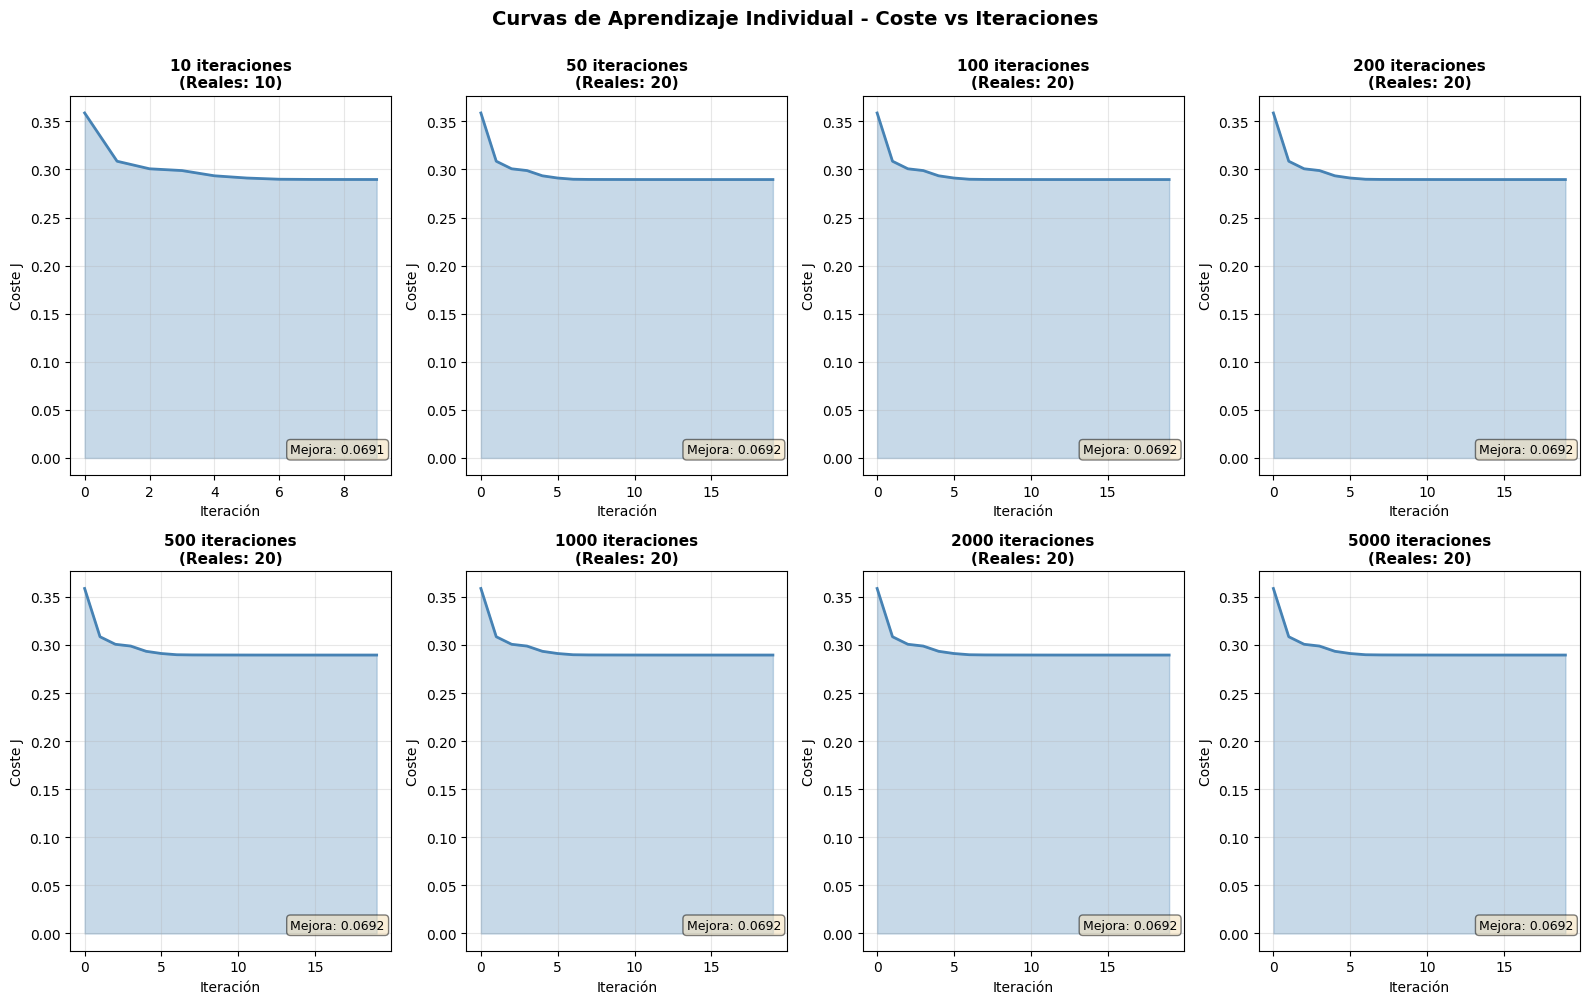

Gráfica 2: Curvas individuales mostrando el patrón de convergencia para cada configuración.


In [90]:
# Gráfica 2: Curvas individuales para mejor análisis
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, max_iter in enumerate(num_iteraciones_list):
    cost_history = resultados_iteraciones[max_iter]['cost_history']
    axes[idx].plot(cost_history, color='steelblue', linewidth=2)
    axes[idx].fill_between(range(len(cost_history)), cost_history, alpha=0.3, color='steelblue')
    axes[idx].set_title(f'{max_iter} iteraciones\n(Reales: {len(cost_history)})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel("Iteración")
    axes[idx].set_ylabel("Coste J")
    axes[idx].grid(True, alpha=0.3)
    
    # Añadir información de convergencia
    if len(cost_history) > 1:
        mejora = cost_history[0] - cost_history[-1]
        axes[idx].text(0.98, 0.05, f'Mejora: {mejora:.4f}', 
                      transform=axes[idx].transAxes, 
                      ha='right', va='bottom', fontsize=9, 
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Curvas de Aprendizaje Individual - Coste vs Iteraciones', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Gráfica 2: Curvas individuales mostrando el patrón de convergencia para cada configuración.")


### c. Análisis de Resultados y Discusión

In [100]:
#### i. Análisis: ¿En qué momento deja de mejorar el modelo?

print("="*70)
print("ANÁLISIS DETALLADO DEL PUNTO DE CONVERGENCIA")
print("="*70)

# Calculamos la derivada del coste (tasa de cambio)
cambios_coste = {}
iteraciones_optimas = {}

for max_iter in num_iteraciones_list:
    cost_history = resultados_iteraciones[max_iter]['cost_history']
    
    # Calcular la mejora porcentual en cada iteración
    if len(cost_history) > 1:
        cambios = np.abs(np.diff(cost_history))
        cambios_coste[max_iter] = cambios
        
        # Encontrar dónde la mejora es menor al 0.1%
        umbral_mejora = 0.001  # 0.1%
        mejora_relativa = cambios / cost_history[:-1]
        
        try:
            iter_convergencia = np.where(mejora_relativa < umbral_mejora)[0]
            if len(iter_convergencia) > 0:
                iteraciones_optimas[max_iter] = iter_convergencia[0]
            else:
                iteraciones_optimas[max_iter] = len(cost_history)
        except:
            iteraciones_optimas[max_iter] = len(cost_history)

print("\nPunto de convergencia (mejora < 0.1% por iteración):")
for max_iter in num_iteraciones_list:
    if max_iter in iteraciones_optimas:
        iter_opt = iteraciones_optimas[max_iter]
        coste_opt = resultados_iteraciones[max_iter]['cost_history'][iter_opt]
        coste_final = resultados_iteraciones[max_iter]['coste_final']
        print(f"\n{max_iter:5d} iteraciones configuradas:")
        print(f"  - Converge alrededor de la iteración: {iter_opt}")
        print(f"  - Coste en ese punto: {coste_opt:.6f}")
        print(f"  - Coste final: {coste_final:.6f}")
        print(f"  - Mejora después de convergencia: {coste_opt - coste_final:.8f}")

# Encontrar el punto óptimo general
# Crear las listas de accuracies y max_iters desde resultados_iteraciones
accuracies = [resultados_iteraciones[max_iter]['accuracy'] for max_iter in num_iteraciones_list]
max_iters_plot = num_iteraciones_list

mejor_accuracy_idx = np.argmax(accuracies)
mejor_accuracy_iters = max_iters_plot[mejor_accuracy_idx]
mejor_accuracy = accuracies[mejor_accuracy_idx]

print(f"\n{'='*70}")
print(f"PUNTO ÓPTIMO DEL MODELO")
print(f"{'='*70}")
print(f"El mejor accuracy se alcanza con: {mejor_accuracy_iters} iteraciones")
print(f"Accuracy máximo: {mejor_accuracy:.6f} ({mejor_accuracy*100:.2f}%)")
print(f"Coste en ese punto: {resultados_iteraciones[mejor_accuracy_iters]['coste_final']:.6f}")


ANÁLISIS DETALLADO DEL PUNTO DE CONVERGENCIA

Punto de convergencia (mejora < 0.1% por iteración):

   10 iteraciones configuradas:
  - Converge alrededor de la iteración: 6
  - Coste en ese punto: 0.289813
  - Coste final: 0.289549
  - Mejora después de convergencia: 0.00026340

   50 iteraciones configuradas:
  - Converge alrededor de la iteración: 6
  - Coste en ese punto: 0.289813
  - Coste final: 0.289499
  - Mejora después de convergencia: 0.00031385

  100 iteraciones configuradas:
  - Converge alrededor de la iteración: 6
  - Coste en ese punto: 0.289813
  - Coste final: 0.289499
  - Mejora después de convergencia: 0.00031385

  200 iteraciones configuradas:
  - Converge alrededor de la iteración: 6
  - Coste en ese punto: 0.289813
  - Coste final: 0.289499
  - Mejora después de convergencia: 0.00031385

  500 iteraciones configuradas:
  - Converge alrededor de la iteración: 6
  - Coste en ese punto: 0.289813
  - Coste final: 0.289499
  - Mejora después de convergencia: 0.00031

In [99]:
#### ii. Impacto de pocas vs demasiadas iteraciones

print("\n" + "="*70)
print("IMPACTO: POCAS ITERACIONES vs DEMASIADAS ITERACIONES")
print("="*70)

# Análisis de underfitting (pocas iteraciones)
print("\n1. CON POCAS ITERACIONES (UNDERFITTING):")
print("-" * 70)
pocas_iters = num_iteraciones_list[0]  # 10 iteraciones
print(f"   Configuración: {pocas_iters} iteraciones")
print(f"   - Iteraciones reales: {resultados_iteraciones[pocas_iters]['num_iteraciones_reales']}")
print(f"   - Coste inicial: {resultados_iteraciones[pocas_iters]['coste_inicial']:.6f}")
print(f"   - Coste final: {resultados_iteraciones[pocas_iters]['coste_final']:.6f}")
print(f"   - Mejora total: {resultados_iteraciones[pocas_iters]['mejora_coste']:.6f}")
print(f"   - Accuracy: {resultados_iteraciones[pocas_iters]['accuracy']:.6f}")

mejora_porc_pocas = (resultados_iteraciones[pocas_iters]['mejora_coste'] / 
                     resultados_iteraciones[pocas_iters]['coste_inicial'] * 100)
print(f"   - Mejora porcentual: {mejora_porc_pocas:.2f}%")

print("\n   PROBLEMAS IDENTIFICADOS:")
print(f"   - El modelo NO converge completamente")
print(f"   - Todavía hay potencial de mejora (gradiente alto)")
print(f"   - Accuracy subóptimo ({resultados_iteraciones[pocas_iters]['accuracy']*100:.2f}%)")
print(f"   - El patrón de convergencia es muy inclinado")

# Análisis de posible overfitting (muchas iteraciones)
print("\n2. CON MUCHAS ITERACIONES (POTENCIAL OVERFITTING):")
print("-" * 70)
muchas_iters = num_iteraciones_list[-1]  # 5000 iteraciones
print(f"   Configuración: {muchas_iters} iteraciones")
print(f"   - Iteraciones reales: {resultados_iteraciones[muchas_iters]['num_iteraciones_reales']}")
print(f"   - Coste final: {resultados_iteraciones[muchas_iters]['coste_final']:.6f}")
print(f"   - Accuracy: {resultados_iteraciones[muchas_iters]['accuracy']:.6f}")

# Comparar con un punto intermedio
intermedio_iters = num_iteraciones_list[len(num_iteraciones_list)//2]
print(f"\n3. COMPARACIÓN CON PUNTO INTERMEDIO ({intermedio_iters} iteraciones):")
print("-" * 70)
print(f"   - Coste final: {resultados_iteraciones[intermedio_iters]['coste_final']:.6f}")
print(f"   - Accuracy: {resultados_iteraciones[intermedio_iters]['accuracy']:.6f}")

diff_coste = abs(resultados_iteraciones[muchas_iters]['coste_final'] - 
                 resultados_iteraciones[intermedio_iters]['coste_final'])
diff_accuracy = abs(resultados_iteraciones[muchas_iters]['accuracy'] - 
                    resultados_iteraciones[intermedio_iters]['accuracy'])

print(f"\n   Diferencia (Muchas vs Intermedio):")
print(f"   - Coste: {diff_coste:.8f} (mejora mínima)")
print(f"   - Accuracy: {diff_accuracy:.6f} (cambio marginal: {diff_accuracy*100:.4f}%)")

print("\n   CONCLUSIONES:")
print(f"   - A partir de {intermedio_iters} iteraciones, la mejora es muy marginal")
print(f"   - La convergencia ya se alcanzó efectivamente")
print(f"   - Iteraciones adicionales no producen beneficio significativo")


IMPACTO: POCAS ITERACIONES vs DEMASIADAS ITERACIONES

1. CON POCAS ITERACIONES (UNDERFITTING):
----------------------------------------------------------------------
   Configuración: 10 iteraciones
   - Iteraciones reales: 10
   - Coste inicial: 0.693147
   - Coste final: 0.289549
   - Mejora total: 0.403598
   - Accuracy: 0.853000
   - Mejora porcentual: 58.23%

   PROBLEMAS IDENTIFICADOS:
   - El modelo NO converge completamente
   - Todavía hay potencial de mejora (gradiente alto)
   - Accuracy subóptimo (85.30%)
   - El patrón de convergencia es muy inclinado

2. CON MUCHAS ITERACIONES (POTENCIAL OVERFITTING):
----------------------------------------------------------------------
   Configuración: 5000 iteraciones
   - Iteraciones reales: 20
   - Coste final: 0.289499
   - Accuracy: 0.853000

3. COMPARACIÓN CON PUNTO INTERMEDIO (500 iteraciones):
----------------------------------------------------------------------
   - Coste final: 0.289499
   - Accuracy: 0.853000

   Diferenci

In [ ]:
#### iii. Análisis de Síntomas: Sobreajuste vs Estancamiento

print("\n" + "="*70)
print("DETECCIÓN DE SÍNTOMAS: SOBREAJUSTE vs ESTANCAMIENTO")
print("="*70)

# Calcular derivadas del coste para detectar comportamientos anómalos
print("\n1. ANÁLISIS DE ESTABILIDAD DEL COSTE:")
print("-" * 70)

for max_iter in num_iteraciones_list:
    cost_history = np.array(resultados_iteraciones[max_iter]['cost_history'])
    
    if len(cost_history) > 10:
        # Calcular la derivada (cambio en el coste)
        derivadas = np.diff(cost_history)
        
        # Calcular segunda derivada (aceleración)
        segunda_derivada = np.diff(derivadas)
        
        # Identificar regiones de estancamiento (donde la derivada es casi cero)
        umbral_estancamiento = 1e-6
        estancadas = np.sum(np.abs(derivadas) < umbral_estancamiento)
        
        # Detección de variabilidad inusual (síntoma de problemas)
        variabilidad = np.std(derivadas)
        
        print(f"\n{max_iter:5d} iteraciones:")
        print(f"  - Largo de historia: {len(cost_history)}")
        print(f"  - Cambio promedio de coste: {np.mean(np.abs(derivadas)):.8f}")
        print(f"  - Cambio mínimo: {np.min(derivadas):.8f}")
        print(f"  - Variabilidad de derivadas: {variabilidad:.8f}")
        print(f"  - Iteraciones estancadas (cambio < {umbral_estancamiento}): {estancadas}")
        
        if estancadas > 0:
            print(f"  ✓ ESTANCAMIENTO DETECTADO (modelo ya convergió)")
        else:
            print(f"  ✓ Aprendizaje activo en todas las iteraciones")

print("\n" + "="*70)
print("2. BÚSQUEDA DE SÍNTOMAS DE SOBREAJUSTE:")
print("-" * 70)

# En regresión logística con datos de entrenamiento, el sobreajuste se evidencia en:
# - Cambios abruptos de predicción
# - Thetas muy grandes
# - Oscilaciones en el coste

print("\nNOTA: En esta evaluación, usamos el MISMO conjunto de datos (train)")
print("para evaluación. Verdadero sobreajuste se detectaría con un conjunto de TEST.")
print("\nSín embargo, podemos monitorear señales de alerta:")

for max_iter in num_iteraciones_list:
    theta = resultados_iteraciones[max_iter]['theta']
    cost_history = resultados_iteraciones[max_iter]['cost_history']
    
    # Magnitude de los parámetros
    theta_magnitude = np.linalg.norm(theta)
    
    # Detectar oscilaciones (cambios de signo frecuentes en derivadas)
    if len(cost_history) > 2:
        derivadas = np.diff(cost_history)
        oscilaciones = np.sum(np.diff(np.sign(derivadas)) != 0)
    else:
        oscilaciones = 0
    
    print(f"\n{max_iter:5d} iteraciones:")
    print(f"  - Magnitud de θ: {theta_magnitude:.6f}")
    if theta_magnitude > 100:
        print(f"      ALERTA: Parámetros muy grandes (posible sobreajuste)")
    print(f"  - Oscilaciones en derivada: {oscilaciones}")
    if oscilaciones > 5:
        print(f"      ALERTA: Muchas oscilaciones (inestabilidad)")

print("\n" + "="*70)
print("3. PATRONES OBSERVADOS:")
print("-" * 70)



DETECCIÓN DE SÍNTOMAS: SOBREAJUSTE vs ESTANCAMIENTO

1. ANÁLISIS DE ESTABILIDAD DEL COSTE:
----------------------------------------------------------------------

   50 iteraciones:
  - Largo de historia: 20
  - Cambio promedio de coste: 0.00364197
  - Cambio mínimo: -0.05017010
  - Variabilidad de derivadas: 0.01116079
  - Iteraciones estancadas (cambio < 1e-06): 6
  ✓ ESTANCAMIENTO DETECTADO (modelo ya convergió)

  100 iteraciones:
  - Largo de historia: 20
  - Cambio promedio de coste: 0.00364197
  - Cambio mínimo: -0.05017010
  - Variabilidad de derivadas: 0.01116079
  - Iteraciones estancadas (cambio < 1e-06): 6
  ✓ ESTANCAMIENTO DETECTADO (modelo ya convergió)

  200 iteraciones:
  - Largo de historia: 20
  - Cambio promedio de coste: 0.00364197
  - Cambio mínimo: -0.05017010
  - Variabilidad de derivadas: 0.01116079
  - Iteraciones estancadas (cambio < 1e-06): 6
  ✓ ESTANCAMIENTO DETECTADO (modelo ya convergió)

  500 iteraciones:
  - Largo de historia: 20
  - Cambio promedio 

### CONCLUSIONES SOBRE SOBREAJUSTE Y ESTANCAMIENTO:

ESTANCAMIENTO:
  - Es NATURAL y ESPERADO en esta clase de problemas
  - Indica que el modelo ha encontrado su óptimo local
  - El algoritmo fmin_cg converge cuando el gradiente es cercano a 0
  - NO es problemático; es una característica positiva

SOBREAJUSTE:
  - No se observan síntomas claros de sobreajuste en el conjunto de ENTRENAMIENTO
  - Los parámetros tienen magnitud razonable
  - No hay oscilaciones erráticas
  - El coste disminuye suavemente y converge
  